## File to create alternate definition of commercial
Jameson Carter

purpose: To recompute the number of commercial buildings according to the zoning maps- this came from the realization that many apartment buildings are listed as commercial in the input data when they are not.

input: pittsburgh_footprint.shp
       sourced from:
       https://openac-alcogis.opendata.arcgis.com/datasets/AlCoGIS::allegheny-county-building-footprint-locations/explore?filters=eyJDTEFTUyI6WyJSIl19&location=40.462063%2C-79.916146%2C16.82
       and city of Pittsburgh 2010 census tract boundaries: https://data.wprdc.org/dataset/2010-census-tracts; additionally we using the zoning map from WPRDC: https://data.wprdc.org/dataset/zoning/resource/58428979-645f-413e-83b5-f06686c40959?inner_span=True
       
pittsburgh_footprint.shp merged from 'Filter footprints for Pittsburgh.ipynb'
       
output: pittsburgh_footprint_clean.shp

In [1]:
import geopandas as gpd
import pandas as pd
#import folium
import matplotlib.pyplot as plt

In [2]:
footprint = gpd.read_file('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/processed_data/pittsburgh_footprint.shp')

In [3]:
zones = gpd.read_file('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/input_data/spatial_data/Zoning.shp')

In [4]:
commercial = zones.loc[zones['legendtype'].isin(['Local Neighborhood Commercial', 'Highway Commercial', 'Urban Neighborhood Commercial'])]
commercial = commercial[['geometry','legendtype']]

In [5]:
footprint_commercial = footprint.sjoin(commercial, how="left", predicate='intersects')
footprint_commercial['CLASS'].unique()

array(['C', 'R', 'G', 'U', 'I', 'F', 'O', None, 'None'], dtype=object)

What I need from the below is the following: a re-coded class for these footprints such that only those WITHIN commercial zoning boundaries count as commercial.

Going to recode them from commercial to 'maybe_commercial_or_apartment'

<AxesSubplot:>

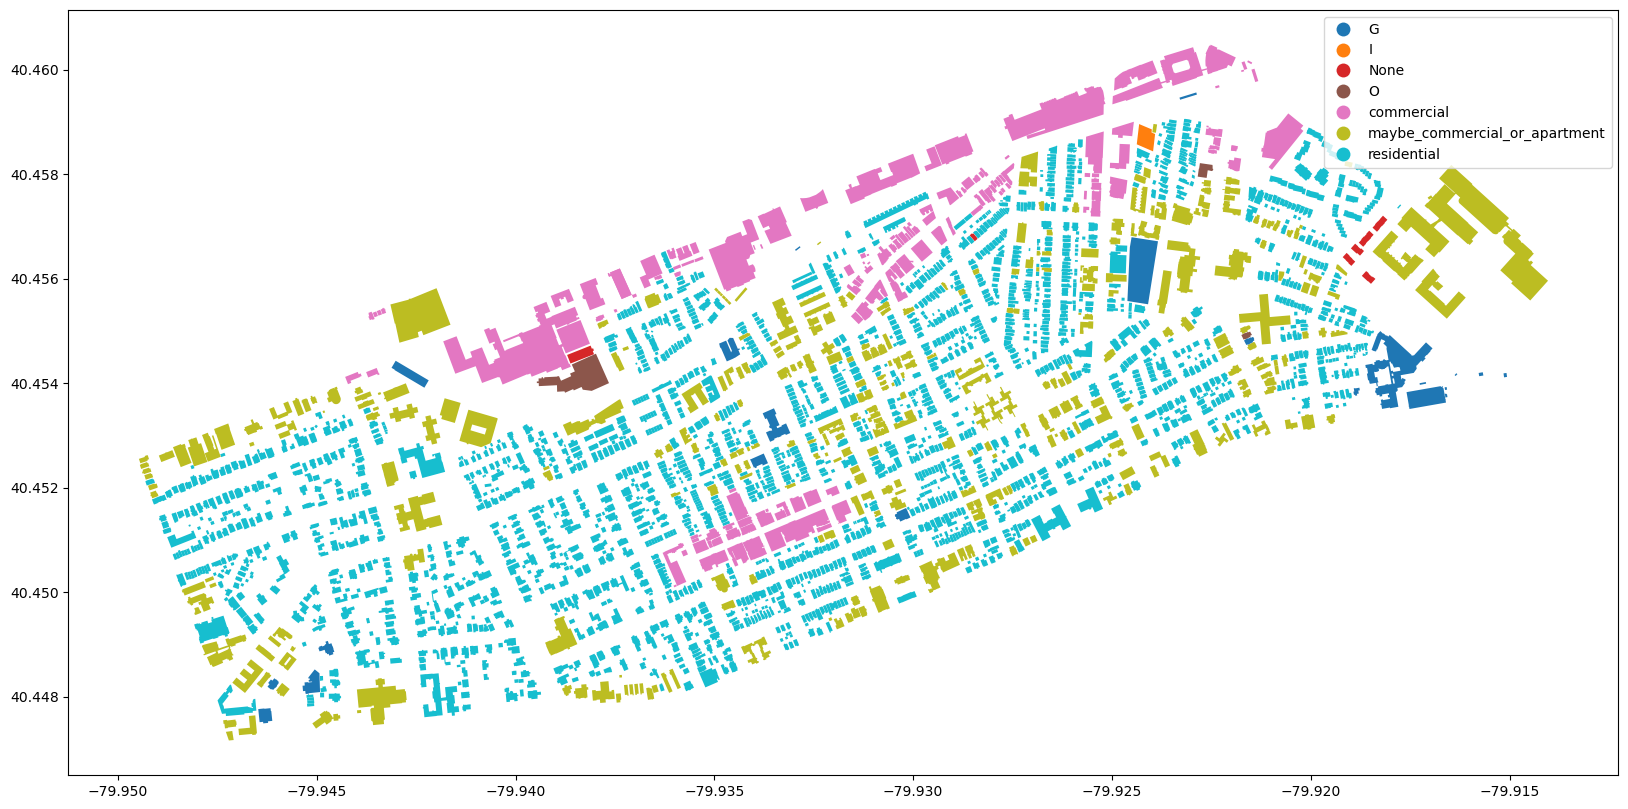

In [11]:
footprint_commercial['class_recode'] = footprint_commercial['CLASS'] # Base the variable off of class, to begin with
# Note that the recode flags commercial buildings not located in the relevant areas as maybe commercial or apartment
# This is to reflect the ambiguity in the data. Apartments will come later...
footprint_commercial.loc[footprint_commercial['class_recode'] == 'C', 'class_recode'] = 'maybe_commercial_or_apartment' # start with baseline commercial classification
footprint_commercial.loc[footprint_commercial['legendtype'].isin(['Local Neighborhood Commercial', 'Highway Commercial', 'Urban Neighborhood Commercial']), 'class_recode'] = 'commercial'
footprint_commercial.loc[footprint_commercial['class_recode'] == 'R', 'class_recode'] = 'residential'


# Let's see shadyside now, for all buildings
plt.rcParams["figure.figsize"]=20,20
shady_all = footprint_commercial.loc[(footprint_commercial['hood']== 'Shadyside')]
#residential.columns
shady_commercial.plot(column='class_recode', legend = True)

In [ ]:
# pittsburgh_footprint_clean.to_file("C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/processed_data/pittsburgh_footprint_clean.shp")
